## importing required libraries

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
import os
import struct
import numpy as np
import random

## procedure to load the data from the json format to rating matrix

In [4]:
# load data after creating features
def load_data_hybrid(data_path, min_items=2, min_users=2, sampling= True, sample_size = 0.5):
    user_ratings = defaultdict(set)
    item_ratings = defaultdict(set)
    max_u_id = -1
    max_i_id = -1
    user_count = 0
    item_count = 0
    reviews = 0
    users = {}  # aid to id LUT
    items = {}  # asid to id LUT
    brands = {}
    prices = {}
    prod_desc = {}
    random.seed(0)
    with open(data_path, 'r') as f:
        bad_actor = 0
        for line in f.readlines()[1:]:
            if (sampling and random.random()>sample_size):
                continue
            reviews += 1
            num_fields = len(line.split(","))
            if (num_fields==6):
                auid, asid, _, brand, price, product_desc = line.split(",")
            elif (num_fields==5):
                auid, asid, _, brand, price = line.split(",")
            else:
                bad_actor = bad_actor + 1
#                 print ("BAD[" + str(bad_actor) + "]" + line)
                continue 

            u, i = None, None

            if auid in users:
                u = users[auid]
            else:
                user_count += 1  # new user so increment
                users[auid] = user_count
                u = user_count
            
            if asid in items:
                i = items[asid]
            else:
                item_count += 1  # new i so increment
                items[asid] = item_count
                i = item_count
                brands[i] = brand
                if (price=='' or price=='\r\n' or price=='\n'):
                    prices[i] = 0
                else:
                    prices[i] = float(price.rstrip())
                if (len(line.split(",")) == 6):
                    prod_desc[i] = [int(el) for el in list(product_desc)[:-1][1:]]
                    if (len(prod_desc[i])==0):
                        prod_desc[i] = list(np.zeros(4525))
            
            user_ratings[u].add(i)
            item_ratings[i].add(u)
            max_u_id = max(u, max_u_id)
            max_i_id = max(i, max_i_id)
            
    print ("max_u_id: ", max_u_id)
    print ("max_i_id: ", max_i_id)
    print ("reviews : ", reviews)
#     print(user_ratings)
#     print(item_ratings)
    
       

    # filter out users w/ less than X reviews
    num_u_id = 0
    num_i_id = 0
    num_reviews = 0
    user_ratings_filtered = defaultdict(set)
    for u, ids in user_ratings.items():
        if len(ids) > min_items:
            # keep
            user_ratings_filtered[u] = ids
            num_u_id += 1
            num_reviews += len(ids)
            
    item_ratings_filtered = defaultdict(set)
    for ids, u in item_ratings.items():
        if len(u) > min_users:
            # keep
            item_ratings_filtered[ids] = u
            num_i_id += 1


    print ("u_id: ", num_u_id)
    print ("i_id: ", num_i_id)
    print ("reviews : ", num_reviews)
    return max_u_id, max_i_id, users, items, user_ratings_filtered, item_ratings_filtered, brands, prices, prod_desc

## LOAD DATA and verify it works properly before passing to session_run function later

In [20]:
data_path = os.path.join('', 'reviews_Women_scraped_cpp_fv.csv')
user_count, item_count, users, items, user_ratings, item_ratings, brands, prices, prod_desc = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)

max_u_id:  34497
max_i_id:  14764
reviews :  144992
u_id:  12349
i_id:  14764
reviews :  84394


In [ ]:
prod_desc

## Procedure to load image features of the products

In [5]:
#load image features for the given asin collection into dictionary
def load_image_features(path, items):
    count=0
    image_features = {}
    f = open(path, 'rb')
    while True:
        asin = f.read(10)
        if asin == '': break
        features_bytes = f.read(16384) # 4 * 4096 = 16KB, fast read, don't unpack
  
        if asin in items: #only unpack 4096 bytes if w need it -- big speed up
            features = (np.fromstring(features_bytes, dtype=np.float32)/58.388599)
            iid=items[asin]
            if len(features)==0:
                image_features[iid] = np.zeros(4096)
            else:
                image_features[iid] = features
    
    return image_features

## Procedure to uniformly sample the (u,i,j) triplet from the raw data for the train set

In [6]:
import tensorflow as tf
import os
import pickle as pickle
import numpy
import random
import matplotlib.pyplot as plt
import sys
import matplotlib.pyplot as plt
%matplotlib inline

def uniform_sample_batch(train_ratings, test_ratings, item_count, advanced_features):
    neg_items = 2
    for u in train_ratings.keys():
        t = []
        iv = []
        jv = []
        for i in train_ratings[u]:
            if (u in test_ratings.keys()):
                if (i != test_ratings[u]):  # make sure it's not in the test set
                    for k in range(1,neg_items):
                        j = random.randint(1, item_count)
                        while j in train_ratings[u]:
                            j = random.randint(1, item_count)
                        # sometimes there will not be an image for given product
                        try:
                            advanced_features[i]
                            advanced_features[j]
                        except KeyError:
                            continue
                        iv.append(advanced_features[i])
                        jv.append(advanced_features[j])
                        t.append([u, i, j])
            else:
                for k in range(1,neg_items):
                    j = random.randint(1, item_count)
                    while j in train_ratings[u]:
                        j = random.randint(1, item_count)
                    # sometimes there will not be an image for given product
                    try:
                        advanced_features[i]
                        advanced_features[j]
                    except KeyError:
                        continue
                    iv.append(advanced_features[i])
                    jv.append(advanced_features[j])
                    t.append([u, i, j])

        # block if queue is full
        if len(iv)>1:
            yield numpy.asarray(t), numpy.vstack(tuple(iv)), numpy.vstack(tuple(jv))
        else:
            continue

## Procedure to uniformly sample the (u,i,j) triplet from the raw data for the test set

In [7]:
def test_batch_generator_by_user(train_ratings, test_ratings, item_ratings, item_count, advanced_features, cold_start = False, cold_start_thresh = 5):
    # using leave one cv
    for u in random.sample(test_ratings.keys(), 4000):
    #for u in test_ratings.keys():
        i = test_ratings[u]
        if (cold_start and len(item_ratings[i]) > cold_start_thresh-1):
            continue
        t = []
        ilist = []
        jlist = []
        count = 0
        for j in random.sample(range(item_count), 100):
            # find item not in test[u] and train[u]
            if j != test_ratings[u] and not (j in train_ratings[u]):
                try:
                    advanced_features[i]
                    advanced_features[j]
                except KeyError:
                    continue

                count += 1
                t.append([u, i, j])
                ilist.append(advanced_features[i])
                jlist.append(advanced_features[j])

        # print numpy.asarray(t).shape
        # print numpy.vstack(tuple(ilist)).shape
        # print numpy.vstack(tuple(jlist)).shape
        if (len(ilist) == 0):
            #print "could not find neg item for user, count: ", count, u
            continue
        yield numpy.asarray(t), numpy.vstack(tuple(ilist)), numpy.vstack(tuple(jlist))

## Procedure to generate the (u,i) pair for the test data

In [8]:
def generate_test(user_ratings):
    '''
    for each user, random select one rating into test set
    '''
    user_test = dict()
    for u, i_list in user_ratings.items():
        user_test[u] = random.sample(user_ratings[u], 1)[0]
    return user_test

## Bayesian Personalized Ranking (BPR) Model and it's extensions (VBPR, NVBPR, Hybrid)

In [9]:
def abpr(user_count, item_count, advanced_features, bpr_extension, hidden_dim=10, hidden_img_dim=10,
         l2_regulization=0.1,
         bias_regulization=0.01,
         embed_regulization = 0,
         image_regulization =0.1,
         visual_bias_regulization = 0.01):
    """
    user_count: total number of users
    item_count: total number of items
    hidden_dim: hidden feature size of MF
    hidden_img_dim: hidden visual/non-visual feature size of MF
    """
  
    advanced_feat_dim = len(advanced_features[1])
    iv = tf.placeholder(tf.float32, [None, advanced_feat_dim])
    jv = tf.placeholder(tf.float32, [None, advanced_feat_dim])
    
    u = tf.placeholder(tf.int32, [None])
    i = tf.placeholder(tf.int32, [None])
    j = tf.placeholder(tf.int32, [None])


  

    
    # model parameters -- LEARN THESE
    # latent factors
    user_emb_w = tf.get_variable("user_emb_w", [user_count + 1, hidden_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
    item_emb_w = tf.get_variable("item_emb_w", [item_count + 1, hidden_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
    # biases
    item_b = tf.get_variable("item_b", [item_count + 1, 1], initializer=tf.constant_initializer(0.0))

    # pull out the respective latent factor vectors for a given user u and items i & j
    u_emb = tf.nn.embedding_lookup(user_emb_w, u)
    i_emb = tf.nn.embedding_lookup(item_emb_w, i)
    j_emb = tf.nn.embedding_lookup(item_emb_w, j)
    
    # get the respective biases for items i & j
    i_b = tf.nn.embedding_lookup(item_b, i)
    j_b = tf.nn.embedding_lookup(item_b, j)


    # MF predict: u_i > u_j
   
    
    if bpr_extension:
        # UxD visual factors for users
        user_img_w = tf.get_variable("user_img_w", [user_count + 1, hidden_img_dim],
                                 initializer=tf.random_normal_initializer(0, 0.1))
        # this is E, the embedding matrix
        img_emb_w = tf.get_variable("img_emb_w", [hidden_img_dim, advanced_feat_dim],
                                initializer=tf.random_normal_initializer(0, 0.1))
        
        theta_i = tf.matmul(iv, img_emb_w, transpose_b=True)  # (f_i * E), eq. 3
        theta_j = tf.matmul(jv, img_emb_w, transpose_b=True)  # (f_j * E), eq. 3

        visual_bias = tf.get_variable("visual_bias", [1, advanced_feat_dim], initializer=tf.random_normal_initializer(0, 0.1))
        # pull out the visual factor, 1 X D for user u
        
        u_img = tf.nn.embedding_lookup(user_img_w, u)
        
        xui = i_b + tf.reduce_sum(tf.multiply(u_emb, i_emb), 1, keep_dims=True) + tf.reduce_sum(tf.multiply(u_img, theta_i), 1, keep_dims=True) \
                                                                            + tf.reduce_sum(tf.multiply(visual_bias, iv), 1, keep_dims=True) 
        xuj = j_b + tf.reduce_sum(tf.multiply(u_emb, j_emb), 1, keep_dims=True) + tf.reduce_sum(tf.multiply(u_img, theta_j), 1, keep_dims=True) \
                                                                            + tf.reduce_sum(tf.multiply(visual_bias, jv), 1, keep_dims=True) 
        l2_norm = tf.add_n([
            l2_regulization * tf.reduce_sum(tf.multiply(u_emb, u_emb)),
            image_regulization * tf.reduce_sum(tf.multiply(u_img, u_img)),
            l2_regulization * tf.reduce_sum(tf.multiply(i_emb, i_emb)),
            l2_regulization * tf.reduce_sum(tf.multiply(j_emb, j_emb)),
            embed_regulization * tf.reduce_sum(tf.multiply(img_emb_w, img_emb_w)),
            bias_regulization * tf.reduce_sum(tf.multiply(i_b, i_b)),
            bias_regulization * tf.reduce_sum(tf.multiply(j_b, j_b)),
            visual_bias_regulization * tf.reduce_sum(tf.multiply(visual_bias, visual_bias))
        ])
        
    
    
    else:
        xui = i_b + tf.reduce_sum(tf.multiply(u_emb, i_emb), 1, keep_dims=True)
        xuj = j_b + tf.reduce_sum(tf.multiply(u_emb, j_emb), 1, keep_dims=True) 
        l2_norm = tf.add_n([
            l2_regulization * tf.reduce_sum(tf.multiply(u_emb, u_emb)),
            l2_regulization * tf.reduce_sum(tf.multiply(i_emb, i_emb)),
            l2_regulization * tf.reduce_sum(tf.multiply(j_emb, j_emb)),
            bias_regulization * tf.reduce_sum(tf.multiply(i_b, i_b)),
            bias_regulization * tf.reduce_sum(tf.multiply(j_b, j_b))
        ])
    
    xuij = xui - xuj

    auc = tf.reduce_mean(tf.to_float(xuij > 0))
    
    loss = l2_norm - tf.reduce_mean(tf.log(tf.sigmoid(xuij)))
    
    train_op = tf.train.AdamOptimizer().minimize(loss)
    
    
    return u, i, j, iv, jv, loss, auc, train_op

## Procedure to run the end-to-end model (from loading data to training the model and to test the model)

In [10]:
def session_run(num_iter, bpr_extension, advanced_features):
    ### Loading and parsing the review matrix for Women 5-core dataset
    auc_train = []
    auc_test = []
    auc_test_cs = []
    data_path = os.path.join('', 'reviews_Women_scraped_cpp_fv.csv')
    user_count, item_count, users, items, user_ratings, item_ratings, brands, prices, prod_desc = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
    user_ratings_test = generate_test(user_ratings)
    with tf.Graph().as_default(), tf.Session() as session:
        with tf.variable_scope('abpr'):
            u, i, j, iv, jv, loss, auc, train_op = abpr(user_count, item_count, advanced_features, bpr_extension=bpr_extension)

        session.run(tf.global_variables_initializer())
        

        for epoch in range(1, num_iter+1):
            print ("epoch ", epoch)
            _loss_train = 0.0
            user_count = 0
            auc_train_values = []
            for d, _iv, _jv in uniform_sample_batch(user_ratings, user_ratings_test, item_count, advanced_features):
                user_count += 1
                _loss, _auc, _ = session.run([loss, auc, train_op], feed_dict={u:d[:,0], i:d[:,1], j:d[:,2], iv:_iv, jv:_jv})
                _loss_train += _loss
                auc_train_values.append(_auc)
            print ("train_loss:", _loss_train/user_count, "train auc: ", numpy.mean(auc_train_values))
            auc_train.append(numpy.mean(auc_train_values))


            auc_values = []
            _loss_test = 0.0
            user_count = 0
            for d, _iv, _jv in test_batch_generator_by_user(user_ratings, user_ratings_test, item_ratings, item_count, advanced_features, cold_start = False):
                user_count += 1
                _loss, _auc = session.run([loss, auc], feed_dict={u: d[:, 0], i: d[:, 1], j: d[:, 2], iv: _iv, jv: _jv})
                _loss_test += _loss
                auc_values.append(_auc)
            print ("test_loss: ", _loss_test / user_count, "test auc: ", numpy.mean(auc_values))
            auc_test.append(numpy.mean(auc_values))

            auc_values_cs = []
            _loss_test_cs = 0.0
            user_count = 0
            for d, _iv, _jv in test_batch_generator_by_user(user_ratings, user_ratings_test, item_ratings, item_count, advanced_features, cold_start = True, cold_start_thresh = 10):
                user_count += 1
                _loss, _auc = session.run([loss, auc], feed_dict={u: d[:, 0], i: d[:, 1], j: d[:, 2], iv: _iv, jv: _jv})
                _loss_test_cs += _loss
                auc_values_cs.append(_auc)
            print ("cold start test_loss: ", _loss_test_cs / user_count, "cold start auc: ", numpy.mean(auc_values_cs))
            auc_test_cs.append(numpy.mean(auc_values_cs))
        return auc_train, auc_test, auc_test_cs

## Loading the image related feature

In [11]:
# Uncomment the lines below to LOAD IMAGE features. It will take some time.
# images_path = "image_features_Women.b"
# f = load_image_features(images_path, items)

## Running the base VBPR model with image features ONLY but no advanced features

In [ ]:
#Uncomment the line below once you have already loaded the image images in f
#vbpr_auc_train, vbpr_auc_test, vbpr_auc_test_cold_start = session_run(5, True, f)

## Running BASELINE BPR with no advanced features at all

In [21]:
#Note: bpr_extension is True only when you are passing image features, else always false

dummy_adv_features= {n: [0] for n in range(1,item_count+1)} # creating dummy array with zero for NO advanced features
bpr_auc_train, bpr_auc_test, bpr_auc_test_cold_start = session_run(5, False, dummy_adv_features)

max_u_id:  34497
max_i_id:  14764
reviews :  144992
u_id:  12349
i_id:  14764
reviews :  84394
epoch  1
train_loss: 0.772080428215 train auc:  0.622693
test_loss:  1.52152486497 test auc:  0.646326
cold start test_loss:  1.57857536205 cold start auc:  0.397217
epoch  2
train_loss: 0.682312924941 train auc:  0.689413
test_loss:  1.23655386198 test auc:  0.65241
cold start test_loss:  1.24502341152 cold start auc:  0.382972


## Generating the price related feature and running the advanced BPR model with price features only

In [17]:
#user_count, item_count, users, items, user_ratings, item_ratings, brands, prices, prod_desc = load_data_hybrid(data_path, min_items=4, min_users=0, sampling= True, sample_size = 0.8)
prices_features= {}
prices_all = list(set(prices.values()))
price_quant_level = 10
price_max = float(max(prices.values()))
for key, value in prices.items():
    prices_vec = numpy.zeros(price_quant_level+1)
    idx = int(numpy.ceil(float(value)/(price_max/price_quant_level)))
    prices_vec[idx]=1
    prices_features[key] = prices_vec


pbpr_auc_train, pbpr_auc_test, pbpr_auc_test_cold_start = session_run(5, False, prices_features)

max_u_id:  34497
max_i_id:  14764
reviews :  144992
u_id:  12349
i_id:  14764
reviews :  84394
epoch  1
train_loss: 0.772155579859 train auc:  0.624427
test_loss:  1.51875085229 test auc:  0.647326
cold start test_loss:  1.58655240667 cold start auc:  0.399437
epoch  2
train_loss: 0.682612460809 train auc:  0.688782
test_loss:  1.23439911182 test auc:  0.652415
cold start test_loss:  1.24013838608 cold start auc:  0.383551
epoch  3
train_loss: 0.645034633056 train auc:  0.707472
test_loss:  1.15654668385 test auc:  0.653579
cold start test_loss:  1.12957013679 cold start auc:  0.383457
epoch  4
train_loss: 0.623630278141 train auc:  0.715868
test_loss:  1.15631887178 test auc:  0.651679
cold start test_loss:  1.12639066083 cold start auc:  0.363224
epoch  5
train_loss: 0.611485291528 train auc:  0.717593
test_loss:  1.19011301042 test auc:  0.658615
cold start test_loss:  1.16516384318 cold start auc:  0.368682


## Generating the brand related feature and running the advanced BPR model with brand features only

In [18]:
brands_features = {}
brands_all = list(set(brands.values()))
for key, value in brands.items():
    brands_vec = numpy.zeros(len(brands_all))
    brands_vec[brands_all.index(value)] = 1
    brands_features[key] = brands_vec
bbpr_auc_train, bbpr_auc_test, bbpr_auc_test_cold_start = session_run(5, False, brands_features)

max_u_id:  34497
max_i_id:  14764
reviews :  144992
u_id:  12349
i_id:  14764
reviews :  84394
epoch  1
train_loss: 0.772099878933 train auc:  0.623456
test_loss:  1.51649618053 test auc:  0.646291
cold start test_loss:  1.56894308648 cold start auc:  0.395977
epoch  2
train_loss: 0.682578504308 train auc:  0.689407
test_loss:  1.2283950308 test auc:  0.652578
cold start test_loss:  1.22937396557 cold start auc:  0.383103


## Generating the product description related feature and running the advanced BPR model with product description generated features only

In [19]:
d = prod_desc
pdbpr_auc_train, pdbpr_auc_test, pdbpr_auc_test_cold_start = session_run(5, False, prod_desc)

max_u_id:  34497
max_i_id:  14764
reviews :  144992
u_id:  12349
i_id:  14764
reviews :  84394
epoch  1
train_loss: 0.772135150108 train auc:  0.624622
test_loss:  1.52538847555 test auc:  0.646207
cold start test_loss:  1.57766490224 cold start auc:  0.396091
epoch  2
train_loss: 0.68261157445 train auc:  0.689998
test_loss:  1.23608737388 test auc:  0.65244
cold start test_loss:  1.24401485626 cold start auc:  0.382935


## Running the advanced BPR model with the hybrid of all non-visual features:  price+brand+product description features (NVBPR)

In [52]:
a = prices_features
b = brands_features
c = dict([(k, numpy.append(a[k],b[k])) for k in set(b) & set(a)])
d= prod_desc
e = dict([(k, numpy.append(c[k],d[k])) for k in set(c) & set(d)])

hybrid_non_visual_features = e
nvbpr_auc_train, nvbpr_auc_test, nvbpr_auc_test_cold_start = session_run(5, False, hybrid_non_visual_features)

max_u_id:  34502
max_i_id:  14779
reviews :  144992
u_id:  12373
i_id:  14779
reviews :  84556
epoch  1
train_loss: 0.83397676466 train auc:  0.622576
test_loss:  2.22193963921 test auc:  0.604957
cold start test_loss:  2.33043541687 cold start auc:  0.452484
epoch  2
train_loss: 0.710886764481 train auc:  0.711418
test_loss:  1.82348409002 test auc:  0.645431
cold start test_loss:  1.85779562236 cold start auc:  0.424151
epoch  3
train_loss: 0.639795182133 train auc:  0.760532
test_loss:  1.74163559884 test auc:  0.652937
cold start test_loss:  1.74590533734 cold start auc:  0.449618
epoch  4
train_loss: 0.576318179312 train auc:  0.798491
test_loss:  1.79236164476 test auc:  0.672374
cold start test_loss:  1.81105523367 cold start auc:  0.48998
epoch  5
train_loss: 0.519506688895 train auc:  0.826072
test_loss:  1.91901169142 test auc:  0.682017
cold start test_loss:  1.93822872405 cold start auc:  0.50498
epoch  6
train_loss: 0.473635795914 train auc:  0.84911
test_loss:  2.01707543

## Running the base advanced BPR model with the hybrid of all visual and non-visual features: image+price+brand+product description features (HBPR)

In [53]:
# uncomment the lines below once you have image features loaded
# hybrid_all_features = dict([(k, numpy.append(e[k],f[k])) for k in set(e) & set(f)])
# hbpr_auc_train, hbpr_auc_test, hbpr_auc_test_cold_start = session_run(5, True, hybrid_all_features)

max_u_id:  34502
max_i_id:  14779
reviews :  144992
u_id:  12373
i_id:  14779
reviews :  84556
epoch  1
train_loss: 0.829893482303 train auc:  0.619778
test_loss:  2.33956347852 test auc:  0.569678
cold start test_loss:  2.43441153348 cold start auc:  0.490776
epoch  2
train_loss: 0.698156786005 train auc:  0.704174
test_loss:  1.99335180886 test auc:  0.612473
cold start test_loss:  2.03011705907 cold start auc:  0.475689
epoch  3
train_loss: 0.610190412864 train auc:  0.763694
test_loss:  1.91133403422 test auc:  0.643724
cold start test_loss:  1.9417069061 cold start auc:  0.529449
epoch  4
train_loss: 0.529283218722 train auc:  0.807396
test_loss:  1.92709438539 test auc:  0.677772
cold start test_loss:  1.95432954565 cold start auc:  0.563544
epoch  5
train_loss: 0.468332351518 train auc:  0.836723
test_loss:  1.98867381583 test auc:  0.698338
cold start test_loss:  2.05932136993 cold start auc:  0.577253
epoch  6
train_loss: 0.423339424614 train auc:  0.858576
test_loss:  2.01198

## comparing Test AUC vs. number of iterations for different models

Text(0.5,0,'Number of Iterations')

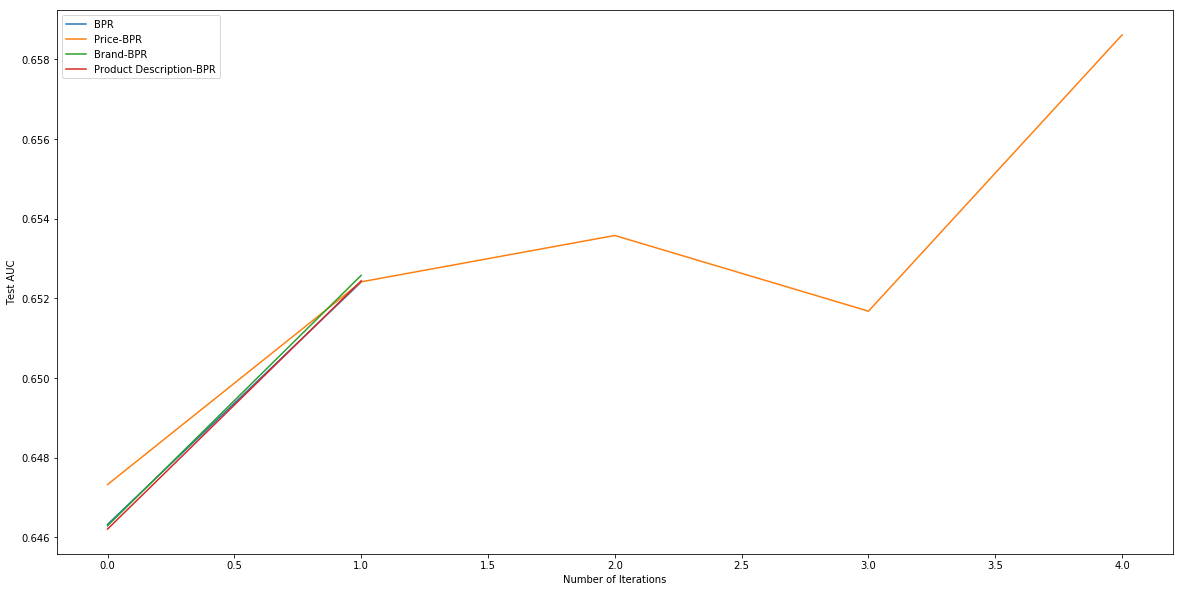

In [22]:
plt.figure(figsize=(20,10))
plt.plot(bpr_auc_test, label = "BPR")
plt.plot(pbpr_auc_test, label = "Price-BPR")
plt.plot(bbpr_auc_test, label = "Brand-BPR")
plt.plot(pdbpr_auc_test, label = "Product Description-BPR")
# plt.plot(nvbpr_auc_test, label = "NonVisual-BPR")
# plt.plot(vbpr_auc_test, label = "Visual-BPR")
# plt.plot(hbpr_auc_test, label = "Hybrid-BPR")
plt.legend()
plt.ylabel("Test AUC")
plt.xlabel("Number of Iterations")

## comparing Cold Start Test AUC vs. number of iterations for different models

Text(0.5,0,'Number of Iterations')

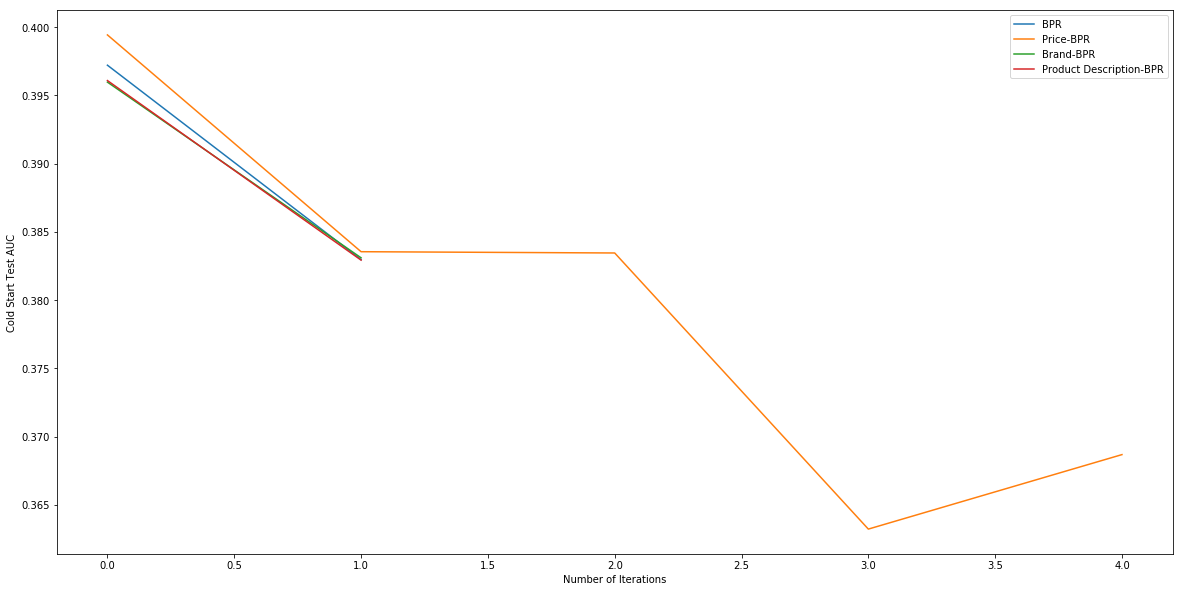

In [23]:
plt.figure(figsize=(20,10))
plt.plot(bpr_auc_test_cold_start, label = "BPR")
plt.plot(pbpr_auc_test_cold_start, label = "Price-BPR")
plt.plot(bbpr_auc_test_cold_start, label = "Brand-BPR")
plt.plot(pdbpr_auc_test_cold_start, label = "Product Description-BPR")
# plt.plot(nvbpr_auc_test_cold_start, label = "NonVisual-BPR")
# plt.plot(vbpr_auc_test_cold_start, label = "Visual-BPR")
# plt.plot(hbpr_auc_test_cold_start, label = "Hybrid-BPR")
plt.legend()
plt.ylabel("Cold Start Test AUC")
plt.xlabel("Number of Iterations")

## Writing the results to a CSV file

In [70]:
import csv
rows = zip(bpr_auc_test, pbpr_auc_test, bbpr_auc_test, pdbpr_auc_test, nvbpr_auc_test, vbpr_auc_test, 
           hbpr_auc_test, bpr_auc_test_cold_start, pbpr_auc_test_cold_start, bbpr_auc_test_cold_start,
          pdbpr_auc_test_cold_start, nvbpr_auc_test_cold_start, vbpr_auc_test_cold_start, hbpr_auc_test_cold_start)

with open("AUC_5core_Women.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerow(["bpr_auc_test", "pbpr_auc_test", "bbpr_auc_test", "pdbpr_auc_test", "nvbpr_auc_test", 
                     "vbpr_auc_test", "hbpr_auc_test", "bpr_auc_test_cold_start", "pbpr_auc_test_cold_start",
                    "bbpr_auc_test_cold_start", "pdbpr_auc_test_cold_start", "nvbpr_auc_test_cold_start",
                    "vbpr_auc_test_cold_start", "hbpr_auc_test_cold_start"])
    for row in rows:
        writer.writerow(row)